## Create the Wastewater File ##

In [1]:
# like runoff, 2-dimensional as we assume wastewater goes in the bottom grid cell
# includes flux, temperature, (salinity is assumed zero) and all the bio tracers too

In [119]:
import datetime as dt
import gsw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyCO2SYS as pyco2
import scipy.io as sio
import xarray as xr

## 1. Coordinates and Area

In [120]:
# what coordinates are you using?
gridcoords = 'coordinates_seagrid_SalishSea201702.nc'
coords_file = '../../../grid/'+gridcoords
mesh = '../../../grid/mesh_mask202108.nc'

In [121]:
#get dimensions for netcdf files
fB = xr.open_dataset(coords_file, decode_times=False)
lat = fB['nav_lat'][:]
lon = fB['nav_lon'][:]
e1t = fB['e1t'][0,:]
e2t = fB['e2t'][0,:]
horz_area = e1t*e2t
print(horz_area[457:460, 343])
fB.close()

<xarray.DataArray (y: 3)>
array([214278.66589227, 214240.63529942, 214202.58325667])
Coordinates:
    time     float32 9.969e+36
Dimensions without coordinates: y


## 1.5 Time

In [122]:
numtimes = 12

## 2. Flux

In [6]:
# flux value, from G1_Wu.pdf Web 
# = 6.3 m^3/s * 1000 kg/m^3
# and need to divide by the number of grid boxes I'm using and the areal size

In [7]:
baseflux = 6.3 * 10**3  / (horz_area[447, 304] + horz_area[446, 305] + 
                          horz_area[447, 305] + horz_area[446, 304])
baseflux

<xarray.DataArray ()>
array(0.00731649)
Coordinates:
    time     float32 9.969e+36

In [123]:
mbathy = xr.open_dataset(mesh).mbathy[0]

In [124]:
print (mbathy[446:448, 304:306])

<xarray.DataArray 'mbathy' (y: 2, x: 2)>
[4 values with dtype=int16]
Dimensions without coordinates: y, x


In [125]:
location = np.array([[27, 447, 304],
            [25, 446, 305],
                    [26, 446, 304],
                     [26, 447, 305]])
location[0, 1]

447

In [11]:
flux = np.zeros_like(horz_area)
for ii in range(location.shape[0]):
    flux[location[ii, 1], location[ii, 2]] = baseflux

In [12]:
flux.sum()

0.029265953321112665

In [126]:

my_struct = sio.loadmat('/ocean/rich/home/metro/VanHarbour/Effluentflow/IonaFlow.mat')

In [127]:
time = np.array(my_struct['Eff'][0][0][0][:, 0])
timestamps = pd.to_datetime(time-719529, unit='D')

In [128]:
rich_flux = np.array(my_struct['Eff'][0][0][1][:,0])
rich_flux

array([5.0212581 , 5.00771759, 5.00706829, ..., 6.70470023, 6.64113889,
       6.71102199])

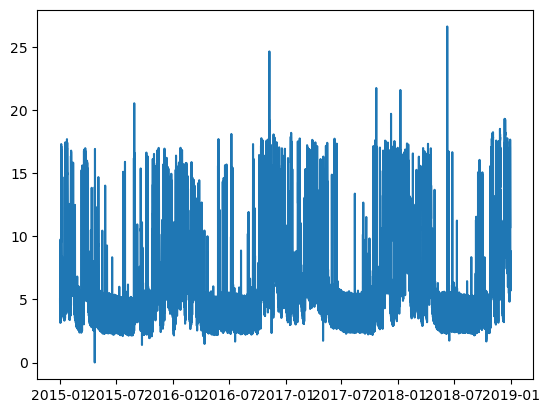

In [129]:
plt.plot(timestamps, rich_flux);

<Axes: >

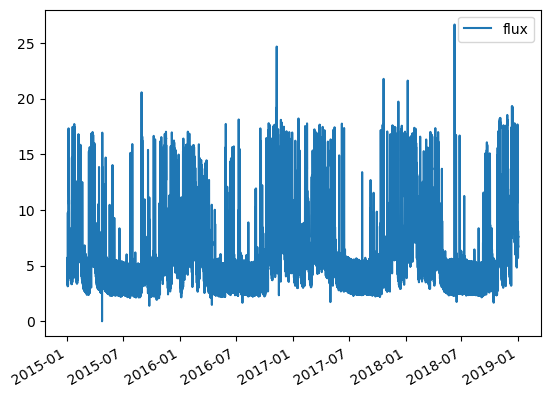

In [130]:
rich_pd = pd.DataFrame(index=timestamps, data=rich_flux, columns=['flux'])
rich_pd.plot()

In [131]:
rich_bymonth = rich_pd.groupby(rich_pd.index.month).mean()
rich_bymonth

,flux
1,8.023214
2,7.513725
3,7.549583
4,6.313632
5,4.928765
6,4.656091
7,4.376797
8,4.327948
9,5.000926
10,6.019049


In [132]:
baseflux = rich_bymonth.flux.values * 10**3  / (horz_area[447, 304] + horz_area[446, 305] + 
                          horz_area[447, 305] + horz_area[446, 304]).values
baseflux

array([0.00931774, 0.00872604, 0.00876769, 0.00733232, 0.00572401,
       0.00540734, 0.00508298, 0.00502625, 0.00580781, 0.00699021,
       0.00978005, 0.01004371])

In [133]:
flux = np.zeros((12, horz_area.shape[0], horz_area.shape[1]))
print (flux.shape)
for ii in range(location.shape[0]):
    flux[:, location[ii, 1], location[ii, 2]] = baseflux

(12, 898, 398)


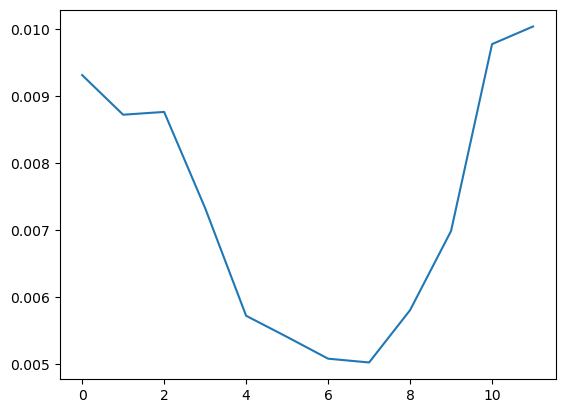

In [134]:
plt.plot(flux[:, location[0, 1], location[0, 2]])

## 3. Temperature

In [135]:
# estimate from Metro File
metro = xr.open_dataset('/ocean/jtao/MOAD/analysis-jake/notebooks/Wastewater.nc')
temperature = metro.temp

In [136]:
temp_conservative = gsw.CT_from_pt(0, temperature)
temp_conservative

<xarray.DataArray 'temp' (time: 12)>
array([12.25173741, 12.69698146, 13.07054269, 15.29609589, 18.07408906,
       19.99636641, 21.41651565, 22.05017901, 21.40395751, 18.86515968,
       16.11926171, 13.66725801])
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Attributes:
    units:      degree_C
    long_name:  Insitu Temperature

In [137]:
temp_cons = np.zeros_like(flux)
for ii in range(location.shape[0]):
    temp_cons[:, location[ii, 1], location[ii, 2]] = temp_conservative

## Other Quantities ##

* nitrate = no2 + no3
* ammonium = nh3
* silicon = Dissolved Silicon, few data, use average.
* diatoms = zeros
* flagellates = zeros
* microzooplankton = zeros
* PON = from biological oxygen demand and volatile suspended solids
* DON from PON and a few DOC measurements
* bSi = zeros
* O2 = do
* TA = alkalinity
* DIC invert from pH and alkalinity

### NH3

In [138]:
metro.nh3 
# mg/L N (14 g/mol)^-1 * 10^3 g/mg / 10^3 mmol/mol * 10^3 L/m^3 = 10^3/14 mmol/m^3
metro.nh3*1000/14

<xarray.DataArray 'nh3' (time: 12)>
array([ 686.27765,  814.1899 ,  809.54504,  949.8829 , 1088.9241 ,
       1196.3303 , 1370.9714 , 1476.7374 , 1314.7439 , 1105.4655 ,
        768.2371 ,  787.59863], dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [139]:
nh3 = np.zeros_like(flux)
for ii in range(location.shape[0]):
    nh3[:, location[ii, 1], location[ii, 2]]  = metro.nh3*1000/14

### Biota (Zeros)

In [140]:
zeros = np.zeros_like(flux)

### Nitrate

In [141]:
no3 = np.zeros_like(flux)
for ii in range(location.shape[0]):
    no3[:, location[ii, 1], location[ii, 2]]  = (metro.no2 + metro.no3)*1000/14

## Silicon

In [142]:
approx_Si = 3.86 * 1000/28.0855  # see my metro file

In [143]:
si = np.zeros_like(flux)
for ii in range(location.shape[0]):
    si[:, location[ii, 1], location[ii, 2]]  = approx_Si

### PON
see details below

In [105]:
106/16

6.625

In [153]:
poc = metro.vss * 0.58 * 1000/12   # 58% of soil is carbon
labile_poc = 0.90 * poc  # based on biological oxygen demand
PON = labile_poc / 34   # terrestrial OM is nitrogen poor
PON

<xarray.DataArray 'vss' (time: 12)>
array([54.832497, 56.63034 , 56.57411 , 58.956326, 61.966446, 60.639282,
       61.707893, 60.52287 , 56.82824 , 55.718586, 51.044403, 53.05486 ],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [154]:
pon = np.zeros_like(flux)
for ii in range(location.shape[0]):
    pon[:, location[ii, 1], location[ii, 2]] = PON

### DON

In [155]:
carbon_oxygen_demand = metro.bod_calc * 1000/16 * 106/138
doc = carbon_oxygen_demand - labile_poc
DON = doc / 34
DON

<xarray.DataArray (time: 12)>
array([41.334644, 56.12226 , 48.244476, 59.061497, 67.99639 , 73.145615,
       70.19817 , 72.69612 , 67.40015 , 59.568165, 40.63507 , 40.910385],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [156]:
don = np.zeros_like(flux)
for ii in range(location.shape[0]):
    don[:, location[ii, 1], location[ii, 2]] = DON

### Oxygen

In [148]:
metro.do * 1000/32

<xarray.DataArray 'do' (time: 12)>
array([276.11606, 241.34615, 235.09616, 209.375  , 182.29167, 134.82143,
       113.39286, 117.78847, 102.14844, 129.5673 , 196.15385, 204.9107 ],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [149]:
do= np.zeros_like(flux)
for ii in range(location.shape[0]):
    do[:, location[ii, 1], location[ii, 2]] = metro.do * 1000/32

### Alkalinity

In [150]:
metro.alkalinity * 1000 /100.0869 # molecular weight of CaCO3

<xarray.DataArray 'alkalinity' (time: 12)>
array([ 862.49493,  937.112  ,  873.1104 , 1017.2796 , 1075.4159 ,
       1140.9143 , 1153.521  , 1176.9478 , 1139.4608 , 1046.6378 ,
        888.04016,  895.82153], dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [151]:
ta = np.zeros_like(flux)
for ii in range(location.shape[0]):
    ta[:, location[ii, 1], location[ii, 2]] = metro.alkalinity * 1000/100.0869

### DIC

See and run section below

In [152]:
dic = np.zeros_like(flux)
for ii in range(location.shape[0]):
    dic[:, location[ii, 1], location[ii, 2]] = results['dic']
dic.max()

1333.018389517296

### Turbidity

https://enpc.hal.science/hal-00722662/document 
TSS = 0.89 * T + 7 with T in FAU  (note that FAU and NTU are sort of the same but measured in different ways).

In [159]:
metro.ss

<xarray.DataArray 'ss' (time: 12)>
array([50.412697, 51.013943, 50.61494 , 51.49899 , 54.044807, 53.6945  ,
       53.267635, 52.4596  , 50.714912, 49.642776, 45.850327, 47.811947],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Attributes:
    units:      mg/L
    long_name:  ToTal Suspended Solids

In [160]:
turb = np.zeros_like(flux)
for ii in range(location.shape[0]):
    turb[:, location[ii, 1], location[ii, 2]] = (metro.ss - 7)/0.89

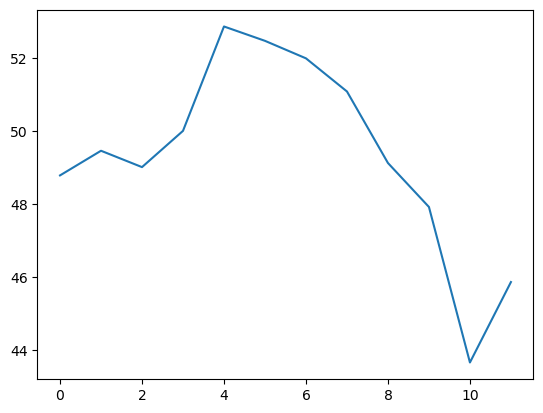

In [162]:
plt.plot((metro.ss-7)/0.89);

In [163]:
# set up titles
netcdf_title = 'wastewater_20231010'
netcdf_comment = netcdf_title+' on '+ gridcoords
notebook = 'Wastewater_File.ipynb'

ds_attrs = {
    'acknowledgements':
            'Based on Metro Data File',
        'creator_email':
            'sallen@eoas.ubc.ca',
        'creator_name':
            'UBC Salish Sea Project Contributors',
        'creator_url':
            'https://salishsea-meopar-docs.readthedocs.org/',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
    'title': netcdf_title,
    'comment': netcdf_comment,
    'notebook': notebook,
    'summary': f'Wastewater, flux, area, and conservative temperature',
    'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
}

coords_c = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
}

coords = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
    'time_counter' : np.arange(numtimes)
}

data_c = {}
var_attrs_c = {} 
data_c['nav_lat'] = lat
var_attrs_c['nav_lat'] = {'units': 'degrees_north',
                       'long_name': 'latitude'}
data_c['nav_lon'] = lon
var_attrs_c['nav_lon'] = {'units': 'degrees_east',
                       'long_name': 'latitude'}
data_c['area'] = horz_area
var_attrs_c['area'] = {'units': 'm2',
                     'long_name': 'horizontal_grid_cell_area'}

da = {}
for var in data_c:
    da[var] = xr.DataArray(
        data = data_c[var],
        name=var,
        dims=('y', 'x'),
        coords = coords_c,
        attrs = var_attrs_c[var])

data = {}
var_attrs = {}

var_attrs['flux'] = {'units': 'kg m-2 s-1',
                      'long_name': 'wastewater_flux'}
data['flux'] = flux

var_attrs['temperature'] = {'units': 'oC',
                      'long_name': 'wastewater conservative temperature'}
data['temperature'] = temp_cons

var_attrs['NO3'] = {'units': 'umol/L',
                    'long_name' : 'wastewater Nitrate + Nitrite'}
data['NO3'] = no3

var_attrs['NH3'] = {'units': 'umol/L',
                    'long_name' : 'wastewater ammonium'}
data['NH3'] = nh3

var_attrs['dSi'] = {'units': 'umol/L',
                    'long_name' : 'wastewater dissolved silion'}
data['dSi'] = si

var_attrs['diatoms'] = {'units': 'umol/L',
                    'long_name' : 'wastewater diatoms'}
data['diatoms'] = zeros

var_attrs['nanoflagellates'] = {'units': 'umol/L',
                    'long_name' : 'wastewater nanoflagellates'}
data['nanoflagellates'] = zeros

var_attrs['Z1'] = {'units': 'umol/L',
                    'long_name' : 'wastewater Z1 zooplankton'}
data['Z1'] = zeros

var_attrs['PON'] = {'units': 'umol/L',
                    'long_name' : 'wastewater labile particulate organic nitrogen'}
data['PON'] = pon

var_attrs['DON'] = {'units': 'umol/L',
                    'long_name' : 'wastewater labile dissolved organic nitrogen'}
data['DON'] = don

var_attrs['bSi'] = {'units': 'umol/L',
                    'long_name' : 'biogenic silicon'}
data['bSi'] = zeros

var_attrs['oxygen'] = {'units': 'umol/L',
                    'long_name' : 'dissolved oxygen'}
data['oxygen'] = do

var_attrs['alkalinity'] = {'units': 'umol/L',
                    'long_name' : 'carbonate alkalinity'}
data['alkalinity'] = ta

var_attrs['DIC'] = {'units': 'umol/L',
                    'long_name' : 'dissolved inorganic carbon'}
data['DIC'] = dic

var_attrs['turb'] = {'units': 'NTU',
                    'long_name' : 'turbidity'}
data['turb'] = turb

for var in data:
    da[var] = xr.DataArray(
        data = data[var],
        name=var,
        dims=('time_counter', 'y', 'x'),
        coords = coords,
        attrs = var_attrs[var])
    

ds = xr.Dataset(
        data_vars={
            'nav_lat': da['nav_lat'],
            'nav_lon': da['nav_lon'],
            'area': da['area'],
            'flux': da['flux'],
            'temperature': da['temperature'],
            'NO3': da['NO3'],
            'NH3': da['NH3'],
            'dSi': da['dSi'],
            'diatoms': da['diatoms'],
            'nanoflagellates': da['nanoflagellates'],
            'Z1': da['Z1'],
            'PON': da['PON'],
            'DON': da['DON'],
            'bSi': da['bSi'],
            'oxygen': da['oxygen'],
            'alkalinity': da['alkalinity'],
            'DIC': da['DIC'],
            'turb': da['turb'],
            },
        coords = coords,
        attrs = ds_attrs
)

ds

<xarray.Dataset>
Dimensions:          (x: 398, y: 898, time_counter: 12)
Coordinates:
  * x                (x) int64 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
  * y                (y) int64 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * time_counter     (time_counter) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables: (12/18)
    nav_lat          (y, x) float32 46.86 46.86 46.86 46.87 ... 51.1 51.1 51.1
    nav_lon          (y, x) float32 -123.4 -123.4 -123.4 ... -124.3 -124.3
    area             (y, x) float64 1.852e+05 1.908e+05 ... 1.764e+05 1.755e+05
    flux             (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    temperature      (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NO3              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...               ...
    DON              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bSi              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    oxygen           (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    alkalinity       (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    DIC              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    turb             (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    acknowledgements:      Based on Metro Data File
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          UBC Salish Sea Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 wastewater_20231010
    comment:               wastewater_20231010 on coordinates_seagrid_SalishS...
    notebook:              Wastewater_File.ipynb
    summary:               Wastewater, flux, area, and conservative temperature
    history:               [2023-10-10] File creation.

In [164]:
encoding = {var: {'zlib': True} for var in ds.data_vars}

In [165]:
ds.to_netcdf(f'./{netcdf_title}.nc', unlimited_dims=('time_counter'),
        encoding=encoding,)

In [146]:
metro

<xarray.Dataset>
Dimensions:      (time: 12)
Coordinates:
  * time         (time) float32 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    temp         (time) float32 ...
    ph           (time) float32 ...
    nh3          (time) float32 9.608 11.4 11.33 13.3 ... 15.48 10.76 11.03
    bod_calc     (time) float32 ...
    cl           (time) float32 ...
    cond         (time) float32 ...
    p_dissolved  (time) float32 ...
    do           (time) float32 ...
    no3          (time) float32 ...
    no2          (time) float32 ...
    alkalinity   (time) float32 ...
    ss           (time) float32 ...
Attributes:
    acknowledgements:      Based on Metro Data File
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          UBC Salish Sea Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 wastewater_20230917
    comment:               wastewater_20230917 on Monthly Time Coordinates
    notebook:              Wastewater_File.ipynb
    summary:               Wastewater, flux, area, and conservative temperature
    history:               [2023-09-28] File creation.

## PON and DON from various fields

In [182]:
boc = metro.bod_calc * 1000/16 * 106/138
boc

<xarray.DataArray 'bod_calc' (time: 12)>
array([3269.6829, 3833.5884, 3563.8318, 4012.606 , 4418.7363, 4548.6865,
       4484.806 , 4529.446 , 4223.765 , 3919.7495, 3117.102 , 3194.8184],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

1     27.800000
2     26.250000
7     30.875385
8     31.363415
9     26.420000
10    15.433333
11    19.900000
12     8.410000

In [183]:
doc_monthly = np.array([27.800000,
26.250000,
30.875385,
31.363415,
26.420000,
15.433333,
19.900000,
8.410000])
doc_monthly.mean()

23.306516625

In [185]:
# doc approx 25 mg/L which is about the half the BOD
doc = doc_monthly.mean() * 1000/12
doc

1942.20971875

In [156]:
metro.ss

<xarray.DataArray 'ss' (time: 12)>
array([50.412697, 51.013943, 50.61494 , 51.49899 , 54.044807, 53.6945  ,
       53.267635, 52.4596  , 50.714912, 49.642776, 45.850327, 47.811947],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Attributes:
    units:      mg/L
    long_name:  Volatile Suspended Solids

as these are volatile, they should be the organic component

What is the average carbon content of soil organic matter?

(58%)
Organic matter is primarily made up of carbon (58%), with the remaining mass consisting of water and other nutrients such as nitrogen and potassium. Carbon is the largest and easiest component of organic matter to measure and as a result SOC is typically measured and reported in a standard soil test.May 17, 2021

https://www.agric.wa.gov.au/soil-carbon/soil-organic-matter-frequently-asked-questions-faqs

And terrestrial matter is usually nitrogen poor.  So 34 C/N.

    https://www.researchgate.net/profile/Ronald-Benner/publication/296187702_Erratum_Major_bacterial_contribution_to_the_ocean_reservoir_of_detrital_organic_carbon_and_nitrogen_Limnology_and_Oceanography_53_1_99-112/links/5f5f581292851c0789651533/Erratum-Major-bacterial-contribution-to-the-ocean-reservoir-of-detrital-organic-carbon-and-nitrogen-Limnology-and-Oceanography-53-1-99-112.pdf

In [186]:
poc = metro.ss * 0.58 * 1000/12
poc

<xarray.DataArray 'ss' (time: 12)>
array([2436.6135, 2465.6738, 2446.3887, 2489.118 , 2612.1658, 2595.2341,
       2574.6023, 2535.547 , 2451.2207, 2399.401 , 2216.099 , 2310.9106],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [187]:
print (doc, doc/poc.mean())

1942.20971875 <xarray.DataArray 'ss' ()>
array(0.78916926)


In [189]:
toc = poc.mean() + doc
toc

<xarray.DataArray 'ss' ()>
array(4403.29101758)

In [190]:
boc.mean()/toc

<xarray.DataArray ()>
array(0.89169705)

So we have 90% labile.  DOC is 80% of POC.

## DIC from pH and TA

https://pyco2sys.readthedocs.io/en/latest/

and in particular example 2  https://github.com/mvdh7/PyCO2SYS-examples/blob/master/CO2SYSExample2.ipynb

In [67]:
# Define input and output conditions
kwargs = dict(
    par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
    par1 = metro.alkalinity.values * 1000/100.0869,  # value of the first parameter
    par2_type = 3,  # The second parameter supplied is of type "3", which means "pH"
    par2 = metro.ph.values,  # value of the second parameter
    salinity = 0.4,  # Salinity of the sample
    temperature = metro.temp.values,  # Temperature at input conditions
    pressure = 0,  # Pressure    at input conditions
    total_silicate = 137,  # Concentration of silicate  in the sample (in umol/kg)
    total_phosphate = metro.p_dissolved*1000/31,  # Concentration of phosphate in the sample (in umol/kg)
    opt_pH_scale = 4,  # pH scale at which the input pH is reported ("4" means "NBS Scale")
    opt_k_carbonic = 8,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("8" means "Millero 79")
    opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
    opt_total_borate = 1,  # Choice of boron:sal ("1" means "Uppstrom")
)
print('Conditions have been defined!')

Conditions have been defined!


In [68]:
# Run PyCO2SYS
results = pyco2.sys(**kwargs)

In [57]:
results['dic']

array([ 983.84790466, 1069.98675809, 1001.00416978, 1157.80791046,
       1215.52131297, 1287.73366426, 1300.85704338, 1333.01838952,
       1277.60813094, 1173.07724771, 1001.83840182, 1013.24572122])

In [44]:
metro.p_dissolved * 1000 / 31

<xarray.DataArray 'p_dissolved' (time: 12)>
array([26142.889, 29002.965, 30842.207, 38271.355, 41692.418, 49907.88 ,
       48173.766, 42150.582, 49440.242, 39903.52 , 27089.19 , 31699.19 ],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0

In [45]:
metro.p_dissolved

<xarray.DataArray 'p_dissolved' (time: 12)>
array([ 810.42957,  899.0919 ,  956.10846, 1186.412  , 1292.465  , 1547.1443 ,
       1493.3867 , 1306.668  , 1532.6475 , 1237.0092 ,  839.7649 ,  982.67487],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Attributes:
    units:      mg/L
    long_name:  Phosphorus Dissolved